# Speech Emotion Recognition

- The objective of this project is to develop a robust speech emotion recognition system capable
of accurately classifying the emotional states conveyed in spoken language.

- By analyzing the acoustic features of speech signals, the system should be able to categorize emotions such as
happiness, sadness, anger, fear, and more.

![](https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs11042-020-10329-2/MediaObjects/11042_2020_10329_Fig1_HTML.png)

In [1]:
#Importing the Libraries
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import librosa
import seaborn as sns
plt.style.use('ggplot')

from keras.models import Sequential
from keras import layers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from IPython.display import Audio
from pydub import AudioSegment, effects
import warnings
warnings.filterwarnings("ignore")

### Loading the data
- We'll merge speech data from four datasets into one dataframe, including file paths, gender labels, and emotion labels.
- Each dataframe's size will be specified, and an example filename with the bolded emotion label will be shown.






In [2]:
#vWe will gather speech data from four datasets and store it in a single dataframe along with the corresponding file paths, gender labels and emotion labels. The size of each respective dataframe will be specified, along with an example filename in which the emotion label is bolded. 
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

 #### Let's check each dataset & print the shpae & sample of it.

In [3]:
#Lets check the Ravdess
ravdess_dir_lis = os.listdir(Ravdess)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {'03' : 'happy','01' : 'neutral', '04' : 'sad','05' : 'angry', '06' : 'fear','07' : 'disgust',}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(Ravdess, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{Ravdess}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

print(ravdess_df.shape)
print(ravdess_df.head())


(1056, 3)
                                                path     sex  emotion
0  /kaggle/input/ravdess-emotional-speech-audio/a...  female  neutral
1  /kaggle/input/ravdess-emotional-speech-audio/a...  female  disgust
2  /kaggle/input/ravdess-emotional-speech-audio/a...  female  disgust
3  /kaggle/input/ravdess-emotional-speech-audio/a...  female  neutral
4  /kaggle/input/ravdess-emotional-speech-audio/a...  female     fear


In [4]:
#Crema-D Dataframe
crema_dir_list = os.listdir(Crema)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {'HAP' : 'happy','NEU' : 'neutral','SAD' : 'sad','ANG' : 'angry', 'FEA' : 'fear','DIS' : 'disgust',}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic and part[3] == 'HI.wav':
        path_list.append(f"{Crema}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

print(crema_df.shape)
print(crema_df.head())

(455, 3)
                                                path     sex  emotion
0  /kaggle/input/cremad/AudioWAV/1032_IEO_HAP_HI.wav    male    happy
1  /kaggle/input/cremad/AudioWAV/1076_IEO_FEA_HI.wav  female     fear
2  /kaggle/input/cremad/AudioWAV/1056_IEO_ANG_HI.wav  female    angry
3  /kaggle/input/cremad/AudioWAV/1038_IEO_SAD_HI.wav    male      sad
4  /kaggle/input/cremad/AudioWAV/1043_IEO_DIS_HI.wav  female  disgust


In [5]:
#Tess Dataframe
tess_dir_list = os.listdir(Tess)
path_list = []
gender_list = []
emotion_list = [] 

emotion_dic = {'happy':'happy','neutral':'neutral', 'sad':'sad','Sad': 'sad','angry' : 'angry','fear': 'fear','disgust': 'disgust',}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(Tess, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        key = part.split('_')[2]
        if key in emotion_dic:
            path_list.append(f"{Tess}{directory}/{audio_file}") 
            gender_list.append('female') # female only dataset
            emotion_list.append(emotion_dic[key])
            
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

print(tess_df.shape)
print(tess_df.head())

(2400, 3)
                                                path     sex emotion
0  /kaggle/input/toronto-emotional-speech-set-tes...  female    fear
1  /kaggle/input/toronto-emotional-speech-set-tes...  female    fear
2  /kaggle/input/toronto-emotional-speech-set-tes...  female    fear
3  /kaggle/input/toronto-emotional-speech-set-tes...  female    fear
4  /kaggle/input/toronto-emotional-speech-set-tes...  female    fear


In [6]:
savee_dir_list = os.listdir(Savee)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {'h'  : 'happy',    'n'  : 'neutral',    'sa' : 'sad','a'  : 'angry',    'f'  : 'fear',    'd'  : 'disgust'}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{Savee}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])
        
savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

print(savee_df.shape)
print(savee_df.head())

(420, 3)
                                                path   sex  emotion
0  /kaggle/input/surrey-audiovisual-expressed-emo...  male    happy
1  /kaggle/input/surrey-audiovisual-expressed-emo...  male     fear
2  /kaggle/input/surrey-audiovisual-expressed-emo...  male    happy
3  /kaggle/input/surrey-audiovisual-expressed-emo...  male  disgust
4  /kaggle/input/surrey-audiovisual-expressed-emo...  male    angry


#### Concatinating all the datasets in df

In [7]:
df = pd.concat([ravdess_df,crema_df, tess_df, savee_df], axis=0)

In [8]:
#Lets check the sample of new dataset
df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


## Exloratory Data Analysis

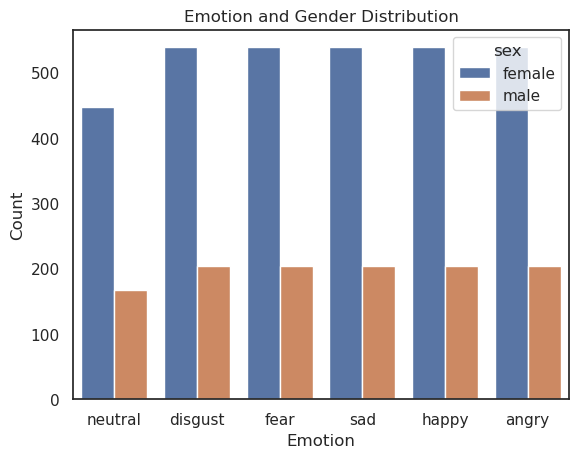

In [9]:
#Distribution of Gender & emotion
sns.set(style="white")
sns.countplot(data=df, x='emotion', hue='sex')
plt.title('Emotion and Gender Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()


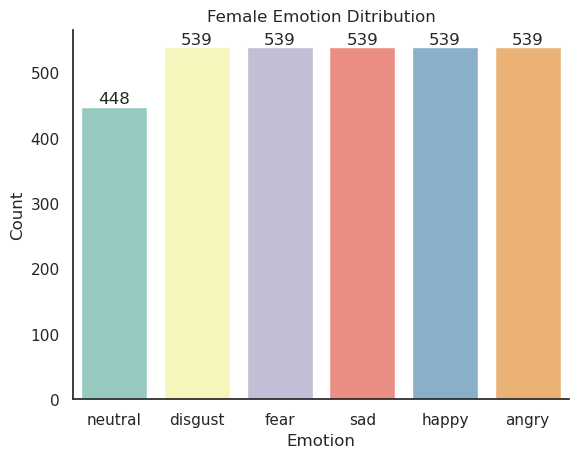

In [10]:
# let's go with a female specific model here
df = df[df['sex'] == 'female']
sns.set(style="white")
ax = sns.countplot(data=df, x='emotion',  palette='Set3')
ax.bar_label(ax.containers[0]) 
plt.title('Female Emotion Ditribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
sns.despine()
plt.show()


In [11]:
#Let's drop the sex column as well
df.drop('sex', axis=1, inplace=True)

#### Plotting the Audio waes

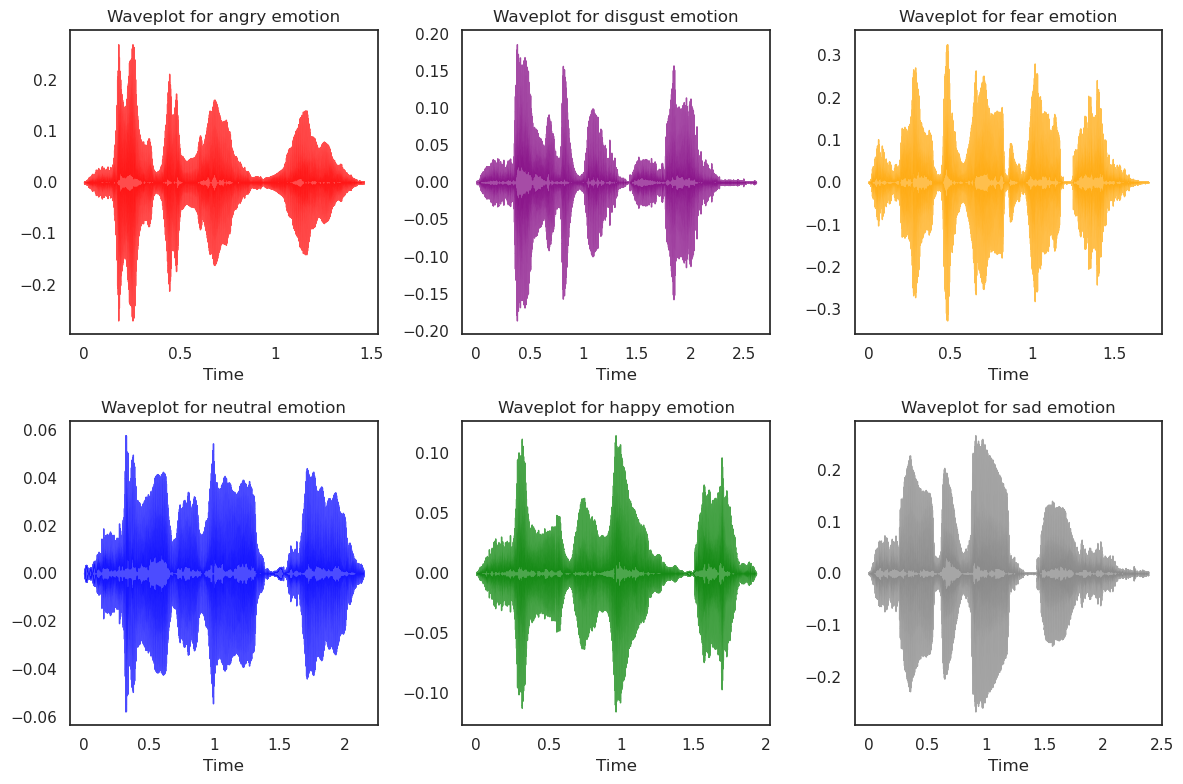

In [12]:
import random
emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
emotion_colors = ['blue', 'green', 'grey', 'red', 'orange', 'purple']

plt.figure(figsize=(12, 8))

displayed_emotions = []
for _ in range(len(emotion_labels)):
    while True:
        emotion_idx = random.randint(0, len(emotion_labels) - 1)
        selected_emotion = emotion_labels[emotion_idx]
        if selected_emotion not in displayed_emotions:
            break
    displayed_emotions.append(selected_emotion)
    emotion_df = df[df.emotion == selected_emotion]

    if not emotion_df.empty:
        random_sample = emotion_df.sample(1)
        path = random_sample.iloc[0]['path']
        y, sr = librosa.load(path)
        plt.subplot(2, 3, len(displayed_emotions))
        plt.title(f"Waveplot for {selected_emotion} emotion")
        librosa.display.waveshow(y, sr=sr, alpha=0.7, color=emotion_colors[emotion_idx])
        display(Audio(path))

plt.tight_layout()
plt.show()

Note : Audio files are in series as per the graphs

### 


In [13]:
#Data Preprocessing
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [14]:
#Assigning Labels to each emotion
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

Since basic EDA & Preprocessing done, lets extract some features
- Extracting below features: 
- Mel-Frequency Cepstral Coefficients: captures the shape of the spectral envelope of a signal
- Zero Crossing Rate: captures the number of times a signal changes sign per second
- Root Mean Square Energy: captures the root mean square amplitude of the audio signal

In [15]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []
FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try: 
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav


In [16]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2), 
    np.swapaxes(rms_list, 1, 2), 
    np.swapaxes(mfccs_list, 1, 2)), 
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')
X.shape

(3142, 352, 15)

### Building a LSTM

![](https://www.researchgate.net/publication/324600237/figure/fig3/AS:616974623178753@1524109621725/Long-Short-term-Memory-Neural-Network.png)




Let's setup the data

In [17]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [18]:
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 352, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 53,894
Trainable params: 53,894
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL.fit(X_train, y_train_class, epochs=150, batch_size=16, validation_data=(X_val, y_val_class))

Epoch 1/150
173/173 [==============================] - 7s 25ms/step - loss: 0.2477 - categorical_accuracy: 0.9096 - val_loss: 0.5051 - val_categorical_accuracy: 0.8295
Epoch 2/150
173/173 [==============================] - 4s 21ms/step - loss: 0.2549 - categorical_accuracy: 0.9045 - val_loss: 0.3899 - val_categorical_accuracy: 0.8636
Epoch 3/150
173/173 [==============================] - 3s 20ms/step - loss: 0.2299 - categorical_accuracy: 0.9175 - val_loss: 0.4608 - val_categorical_accuracy: 0.8523
Epoch 4/150
173/173 [==============================] - 3s 20ms/step - loss: 0.2466 - categorical_accuracy: 0.9063 - val_loss: 0.4595 - val_categorical_accuracy: 0.8561
Epoch 5/150
173/173 [==============================] - 4s 21ms/step - loss: 0.2498 - categorical_accuracy: 0.9052 - val_loss: 0.4129 - val_categorical_accuracy: 0.8409
Epoch 6/150
173/173 [==============================] - 3s 20ms/step - loss: 0.2411 - categorical_accuracy: 0.9099 - val_loss: 0.4190 - val_categorical_accuracy:

### Model Evaluation

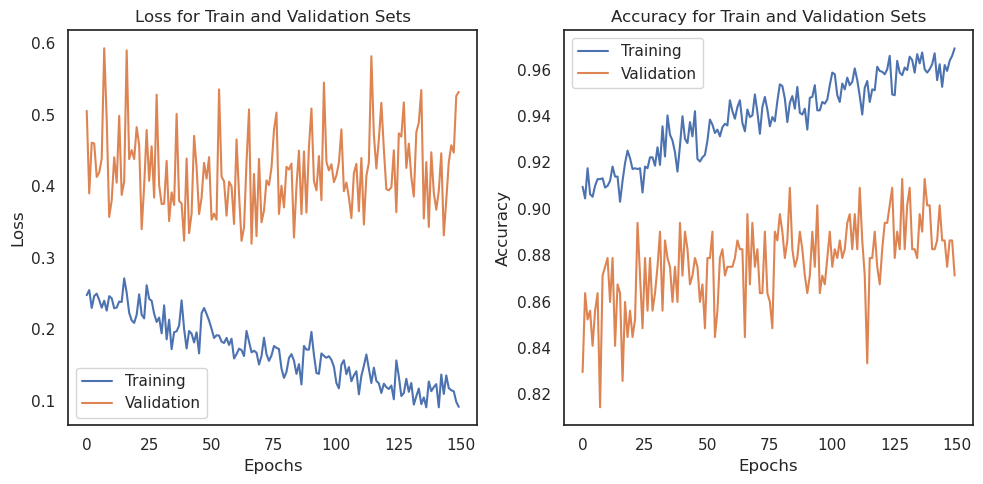

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

9/9 [==============================] - 0s 19ms/step


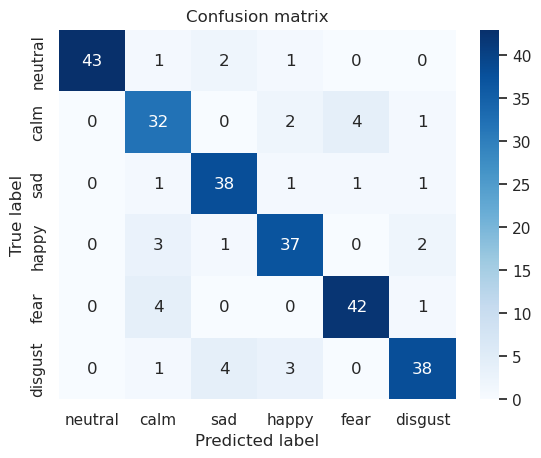

In [31]:
y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

The model achieved aprox 87% accuracy in classifying the six different emotions.